# Fast exponential and softmax functions

Based on the bit manupulation of the IEEE 754 floating point numbers.
See N. N. Schraudolph, “A Fast, Compact Approximation of the Exponential Function,” Neural Computation, vol. 11, no. 4, pp. 853–862, May 1999, doi: 10.1162/089976699300016467.

A 32-bit floating point number is given by:
$$ x = (-1)^s (1+m)2^{e-127} $$
where $s$ - sign bit; $m$ - 23-bit mantissa; $e$ - 8-bit exponent;

For bit layout see [this diagram](https://upload.wikimedia.org/wikipedia/commons/d/d2/Float_example.svg).

Writing some integer value $i$ in bit field of the exponent and read back as a float number will give value of$2^{i-127}$. 

So dividing $x$ by dividing by $\ln(2)$, shifting the value $x/\ln(2)+127$ by 23 bit, and reading back the bits of resulting integer number as a flot will give value of the $e^x$. Correction factor $C$ allows adjusting the approximation for some parameters.

$$f(x) = 2^{23} \left(\frac{x}{\ln(2)} + 127 - C\right)$$
In some example following approximation is used with specific values in code $C = 0.057985$:
```C
uint32_t value = (1<<23)*(1.4426950409*x+126.94201519f);
```
Which is then bitcast to floating point number via union type punning.


## Softmax

Softmax is a function over a vector $\mathbf{X}$:

$$ \sigma(\mathbf{X})_i = \frac{e^{x_i}}{\sum\limits_{j=0}^{N}e^{x_j}} $$


When calculating softmax the maximum is substracted from initial data for numerical stability - to avoid overflows.


C = 0.057985
0.6931471805599453
A 12102203.000000
C 1064866816.000000
Upper bound: 2.000000
Lower bound: 4435613.826217
Lowest maximum relative error: gamma = 0.030275
Lowest maximum relative error: c = 366392.997292 0.043677
Lowest RMS error: c = 486411.880684 0.057985
Lowest mean error: c = 545947.460827 0.065082
exp
True                      | max err = 0.000000 | rms err = 0.000000 
fast_exp                  | max err = 3.935927 | rms err = 1.770331 
int_fast_exp_rem          | max err = 3.793207 | rms err = 1.868613 
int_fast_exp_fast         | max err = 7.565044 | rms err = 2.450129 
int_fast_exp_rem_lut      | max err = 0.000012 | rms err = 0.545638 
int_fast_exp_fast_lut     | max err = 3.939233 | rms err = 1.671804 
softmax
True                      | max err = 0.000000 | rms err = 0.000000 
fast_exp                  | max err = 3.939733 | rms err = 1.770343 
int_fast_exp_rem          | max err = 2.455899 | rms err = 2.483500 
int_fast_exp_fast         | max err = 6.080414 | r

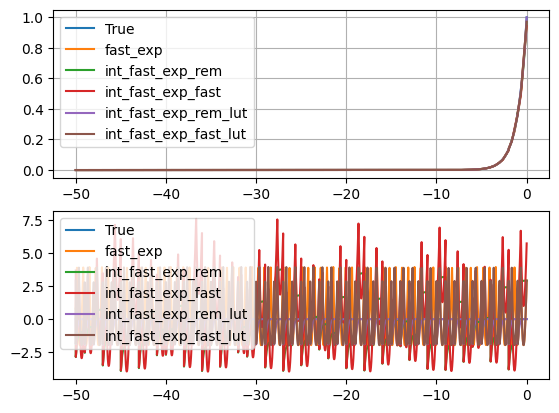

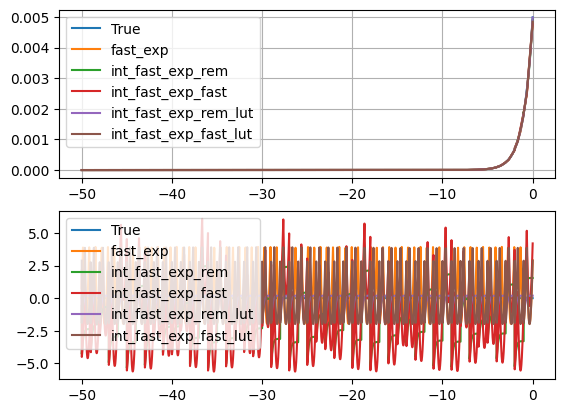

In [92]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial

SIZE = 10000

C = 127 - 126.94201519

print("C = {:f}".format(C))
print(1 / np.log2(np.e))

print("A {:f}".format(np.float32(1.4426950409) * np.float32(1 << 23)))
print("C {:f}".format(np.float32(126.94201519) * np.float32(1 << 23)))


def fast_exp(x, c=C):
    A = np.float32(1.4426950409) * np.ones((SIZE), np.float32)
    K = np.float32(1 << 23) * np.ones((SIZE), np.float32)
    y = np.multiply(K, (A * x + 127 - c), dtype="f")
    z = np.int32(y)
    v = z.view(np.float32)
    return v


def int_fast_exp(x):
    A = np.int32(12102203)
    C = np.int32(1064866815)
    v = np.int32(x) * A + C
    return v.view(np.float32)


def taylor_exp(x, q=5):
    result = 1
    el = result
    for i in range(1, q):
        el = el * x / i
        result = result + el
    return result

def int_fast_exp_rem(x):
    intp = np.int32(x)
    rem = x - intp
    return int_fast_exp(intp) * taylor_exp(rem)


def int_fast_exp_rem_lut(x):
    intp = np.int32(x)
    rem = x - intp
    return np.exp(intp) * taylor_exp(rem)


def int_fast_exp_fast(x):
    intp = np.int32(x)
    rem = x - intp
    return int_fast_exp(intp) * fast_exp(rem)


def int_fast_exp_fast_lut(x):
    intp = np.int32(x)
    rem = x - intp
    return np.exp(intp) * fast_exp(rem)


def fast_log(x):
    sigma = 0.0430357
    v = x.view(np.int32)
    return 0.6931471805599453 * np.float32(v / (2**23) - (127 - sigma))


def fast_exp_newtons(x):
    y = fast_exp(x)
    y2 = y - y * fast_log(y) + y * x
    return y2


def fast_exp_newtons2(x):
    y = fast_exp(x)
    y2 = y - y * fast_log(y) + y * x
    y3 = y2 - y2 * fast_log(y2) + y2 * x
    return y3


def bounds():
    print("Upper bound: {:f}".format(fast_exp([0], -1)[0]))
    print(
        "Lower bound: {:f}".format(2**23 * ((1 - (np.log(np.log(2)) + 1)) / np.log(2)))
    )
    gamma = np.log(np.log(2) + 2 / np.e) - np.log(2) - np.log(np.log(2))
    c = gamma * 2**23 / np.log(2)
    print("Lowest maximum relative error: gamma = {:f}".format(gamma))
    print("Lowest maximum relative error: c = {:f} {:f}".format(c, c / 2**23))
    c = np.log(3 / (8 * np.log(2)) + 0.5) / np.log(2)
    print("Lowest RMS error: c = {:f} {:f}".format(2**23 * c, c))
    gamma = 0.045111411
    c = gamma / np.log(2)
    print("Lowest mean error: c = {:f} {:f}".format(2**23 * c, c))


def softmax(x, func):
    exps = func(x)
    sums = np.sum(exps)
    return func(x) / sums


def get_err(x, tr, app):
    return 100 * (tr(x) - app(x)) / tr(x)


def plot(x, funcs, labels):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.grid(True)
    i = 0
    for func in funcs:
        ax1.plot(x, func(x))
        err = get_err(x, funcs[0], func)
        ax2.plot(x, err)
        print("{:25s} | max err = {:f} | rms err = {:f} ".format(labels[i], max(err), np.sqrt(np.mean(err**2))))
        i = i + 1
    ax1.legend(labels)
    ax2.legend(labels)
    


bounds()

x = np.linspace(-50, 0.0, SIZE, dtype=np.float32)
print("exp")
plot(
    x,
    [
        np.exp,
        fast_exp,
        int_fast_exp_rem,
        int_fast_exp_fast,
        int_fast_exp_rem_lut,
        int_fast_exp_fast_lut,
    ],
    [
        "True",
        "fast_exp",
        "int_fast_exp_rem",
        "int_fast_exp_fast",
        "int_fast_exp_rem_lut",
        "int_fast_exp_fast_lut",
    ],
)
print("softmax")
plot(
    x,
    [
        partial(softmax, func=np.exp),
        partial(softmax, func=fast_exp),
        partial(softmax, func=int_fast_exp_rem),
        partial(softmax, func=int_fast_exp_fast),
        partial(softmax, func=int_fast_exp_rem_lut),
        partial(softmax, func=int_fast_exp_fast_lut),
    ],
    [
        "True",
        "fast_exp",
        "int_fast_exp_rem",
        "int_fast_exp_fast",
        "int_fast_exp_rem_lut",
        "int_fast_exp_fast_lut",
    ],
)
# x2 = np.linspace(0.5, 10.0, SIZE, dtype=np.float32)
# plot(x2, [np.log, fast_log], ["True", "Fast log"])